## S & P 500 Index Direction Prediction

    - Ade Idowu

## Agenda
    - Problem specification
    - Some brief comments on the Data source
    - Feature Extraction
    - Data Exploration
    - ML Models for classification
    - Model construction
    - Model performance
    - Conclusions and Q&A

### Problem specification:
- Analyse the S & P 500 Stock Index data for a 5 year historical peroiod i.e. from 2001 to 2005.
- The data will be composed of daily returns (including lagged daily returns), volume and index direction
- Develop a predictive model that can be used to predict the daily direction of the index (i.e. is it going up or down)
- The model will be used to predict the index direction based on explanatory/feature variables such as daily returns, lagged daily returns (for lags upto 5 days), Volume and Year
- This is a classification supervised learning problem 
- A number of classification models that range from simple linear (such as Naive Bayes or Logistic Regression) to non-linear (such as non-linear SVM or MLP Neurak Network) models be experimented in this project
- Each model will be compare to one another and the best performing model will be identified
- All of the modelling libraries/framework used in this project will be based on open source data
- The practical objective of this project is build a robust and highly generalised model (i.e with low bias/variance) that can be use to potentially provide trading signals for the predicted market direct. These signals can used to aided an automated algo trading system 

Further reference: 
[An Introduction to Statistical Learning](https://www-bcf.usc.edu/~gareth/ISL/) 


### Define the imports

In [1]:
import numpy as np
import pandas as pd
import keras.models as km
import keras.layers as kl
import sklearn.preprocessing as spp
import sklearn.model_selection as smo
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nbuser/anaconda3_420/lib/pyth

### Source Data for the Problem
 - Problem source data is a csv extract of S & P 500 index from 2001 to 2005
 - The data contains trading indicator information such as returns (current/lagged) and volume typically obtained from Open-high-low-close (OHLC) and volume data

In [16]:
def demoProblemSourceData():
    '''
    Provides an overview of the problem source data i.e. returns, and lagged returns and volume data 
    '''
    stock_market_data_table = pd.read_csv("data/S_Market_Data_ISRL.csv", sep=",",index_col=0)
    cols = stock_market_data_table.columns.values.tolist()
    print("The S & P data contains the following columns:\n{}\n".format(cols))
    print("Some data rows:\n{}".format(stock_market_data_table.head()))
    return stock_market_data_table, cols
    


In [17]:
stock_market_data_table, cols = demoProblemSourceData()

The S & P data contains the following columns:
['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']

Some data rows:
   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
1  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
2  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
3  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
4  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
5  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up


### Feature engineering
 - Extraction of the return (current/today and lagged) and Direction variables [althogh I am not going to go into to much detail]
 - A minor feature enginerring step is required to make the Direction (output vector) a numeric values (i.e. encoded as 0 or 1) rather than a string

#### Do some feature extraction on the S&P 500 Index data to compute the returns and market direction:
- Code shown below

In [38]:
class SP500IndexDatafeatureExtractor(object):
    '''
    Component used to extract features (such as current/lagged returns, direction) from the S&P500 Index data
    '''
    def __init__(self, sp500):
        self._sp500 = sp500.copy()
        
    def displaySP500IndexDataBefore(self):
        '''
        Dispalys the S&P500 data before the feature extraction
        '''
        print("Sample S&P500 before feature extraction:\n{}\n".format(self._sp500.head(10)))
    
    def execute(self, is_drop_na=True):
        '''
        Executes the feature extraction
        '''
        def getMarketDirection(r):
            if r['next_close'] > r['next_open']:
                return 'up'
            else:
                return 'down'
        self._sp500['next_open'] = self._sp500.open.shift(-1)
        self._sp500['next_close'] = self._sp500.close.shift(-1)
        self._sp500['Direction'] = self._sp500.apply(getMarketDirection, axis=1)
        self._sp500['Today'] = ((self._sp500['close'] - self._sp500['close'].shift(1))/self._sp500['close'].shift(1))*100
        self._sp500['date'] = pd.to_datetime(self._sp500['date'])
        self._sp500['Year'] = self._sp500.apply(lambda x: x['date'].date().year, axis=1)
        for i in list(range(1, 6, 1)):
            self._sp500['Lag{}'.format(i)] = self._sp500['Today'].shift(i)
        new_cols = ['Year', 'volume', 'Today', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Direction']
        sp500_new = self._sp500.copy()
        sp500_new2 = sp500_new[new_cols]
        sp500_new2.rename(columns={'volume': 'Volume'}, inplace=True) 
        if is_drop_na:
             sp500_new2 = sp500_new2.dropna()
        return sp500_new2
        
    def displaySP500IndexDataAfter(self):
        '''
        Dispalys the S&P500 after the feature extraction
        '''
        sp500_new = self.execute()
        sp500_new.head(10)
        print("\nSample S&P500 after feature extraction:\n{}\n".format(sp500_new.head(10)))

def demoReturenAndDirectionFeatureExtraction():       
    s_and_p_500_2013_to_2018 = 'data/S_Market_Data_2013_to_2018_from_Nasdaq.csv'
    sp500 = pd.read_csv(s_and_p_500_2013_to_2018)
    extractor = SP500IndexDatafeatureExtractor(sp500)
    extractor.displaySP500IndexDataBefore()
    extractor.displaySP500IndexDataAfter()


In [39]:
demoReturenAndDirectionFeatureExtraction()

Sample S&P500 before feature extraction:
         date   close       volume    open    high       low
0  2018/09/28  290.72   70041610.0  289.99  291.28  289.9500
1  2018/09/27  290.69   59169340.0  290.41  291.91  290.1000
2  2018/09/26  289.88   79534430.0  290.91  292.24  289.4100
3  2018/09/25  290.75   44311990.0  291.53  291.65  290.4833
4  2018/09/24  291.02   53235550.0  291.34  291.50  290.3700
5  2018/09/21  291.99  105393700.0  293.09  293.22  291.8100
6  2018/09/20  293.58  100066700.0  292.64  293.94  291.2363
7  2018/09/19  291.22   48973100.0  290.97  291.69  290.8250
8  2018/09/18  290.91   61839370.0  289.58  291.58  289.5500
9  2018/09/17  289.34   67988580.0  290.82  290.86  289.0300


Sample S&P500 after feature extraction:
    Year       Volume     Today      Lag1      Lag2      Lag3      Lag4  \
6   2018  100066700.0  0.544539  0.333310  0.092863  0.300124 -0.278647   
7   2018   48973100.0 -0.803869  0.544539  0.333310  0.092863  0.300124   
8   2018   61839370.0

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [40]:
def makeDirectionVectorNumeric():
    '''
    Make the Direction (output vector) a numeric values (0 or 1) rather than a string
    '''
    stock_market_data_table.Direction = stock_market_data_table.Direction.apply(lambda x: 1 if x == 'Up' else 0)

makeDirectionVectorNumeric()

### Exploration of the S & P 500 Index data
 - Let us explore the time-series of the 'Today' returns feature variable 
 - Let us have a look at the descriptive statistics of the problem data
 - Analyse the distribution of all the feature variables and the output
 - Use a Boxplot to understand the distribution of some of the feature variables (Today/lagged returns) with respect to the output (Direction of index)
 - Let us use Pearson Correlation metric to understand the relationship/correlation between the feature variables and the output

#### Display Daily Return Time-series

In [41]:
def plotTodayReturnTimeSeries():
    '''
    Exploration of the time-series of the 'Today' returns feature variable
    '''
    fig, ax = plt.subplots(figsize=(12,10))
    stock_market_data_table['Today'].plot(color='k')
    plt.title("S & P 500 Index (SPY) time-series plot", fontsize=20)
    plt.xlabel("Days", fontsize=20)
    plt.ylabel("Today's Return", fontsize=20)
    


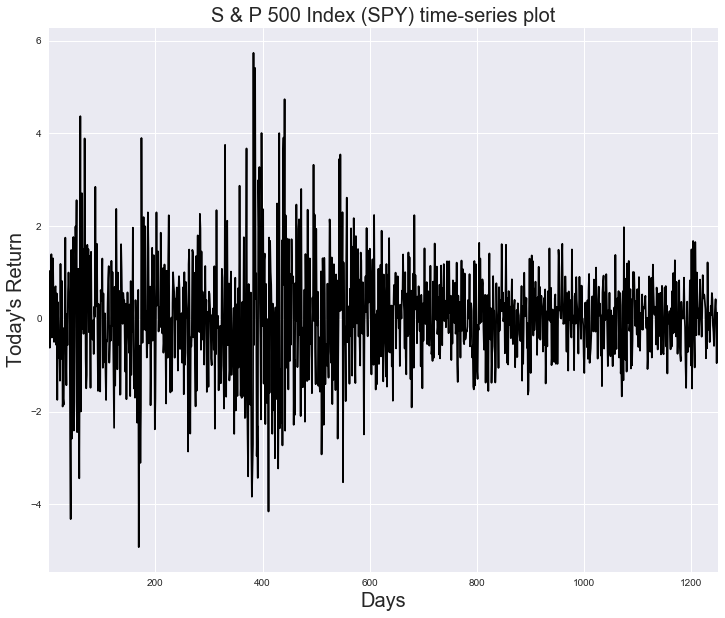

In [42]:
plotTodayReturnTimeSeries()

#### Display the Descriptive Stats

In [43]:
from tabulate import tabulate

def displayDataDescriptiveStats():
    '''
    Let us have a look at the descriptive statistics of the problem data
    '''
    print("S&P descriptive stats:\n\n{}\n".format(stock_market_data_table.describe()))
    


In [44]:
displayDataDescriptiveStats()

S&P descriptive stats:

              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250.000000  1250.000000  1250.000000   
mean   2003.016000     0.003834     0.003919     0.001716     0.001636   
std       1.409018     1.136299     1.136280     1.138703     1.138774   
min    2001.000000    -4.922000    -4.922000    -4.922000    -4.922000   
25%    2002.000000    -0.639500    -0.639500    -0.640000    -0.640000   
50%    2003.000000     0.039000     0.039000     0.038500     0.038500   
75%    2004.000000     0.596750     0.596750     0.596750     0.596750   
max    2005.000000     5.733000     5.733000     5.733000     5.733000   

             Lag5       Volume        Today    Direction  
count  1250.00000  1250.000000  1250.000000  1250.000000  
mean      0.00561     1.478305     0.003138     0.518400  
std       1.14755     0.360357     1.136334     0.499861  
min      -4.92200     0.356070    -4.922000     0.000000  
25%      -0.64

#### Display Data Distributions

In [45]:
def plotDataDistributions():
    '''
    Plots the histogram/distributions of all the data vectors
    '''
    plt.rcParams["figure.figsize"] = (20,10)
    print("Histogram/distributions of all the data vectors:\n")
    ax = stock_market_data_table.hist()
    print("\n")


Histogram/distributions of all the data vectors:





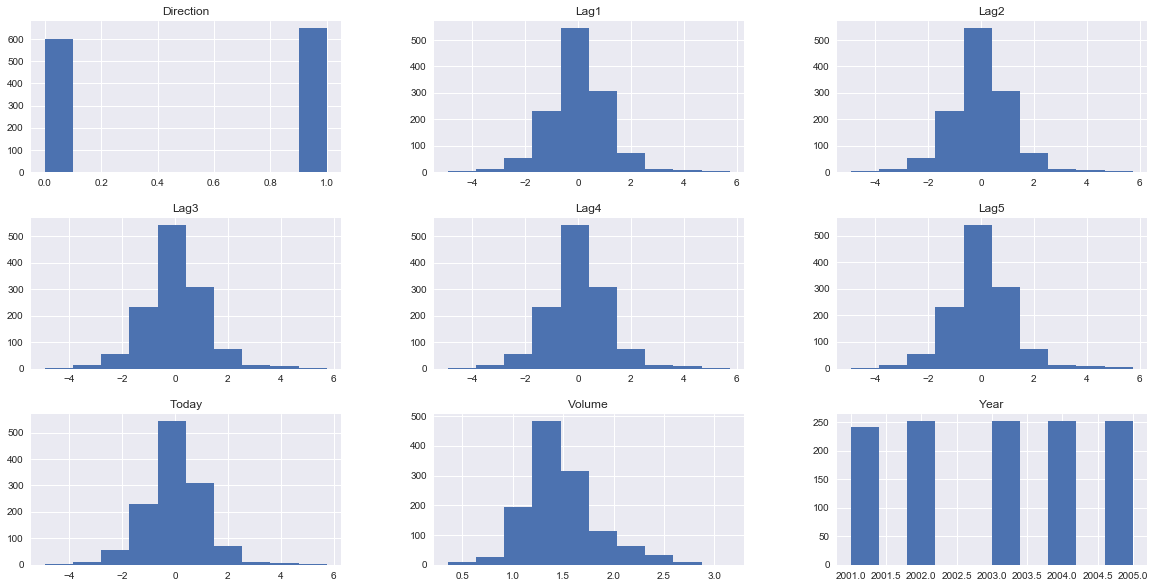

In [46]:
plotDataDistributions()

### Display Boxplots of some features

In [47]:
def plotBoxplotOfReturnVariables():
    def plotBoxplotOfReturnVariable(feature_names, output_name, data):
        '''
        Create a Boxplot for 2 features wrt Direction
        '''
        fig, axes =plt.subplots(1,2)
        sns.set_style("darkgrid")
        flatui = [  "#95a5a6",  "#34495e"]
        for i,t in enumerate(feature_names):
            sns.boxplot(  y=t, x= output_name, data=data,  orient='v',ax=axes[i % 2] ,  palette= flatui)
        
    feature_names1 = ['Today', 'Lag1']
    feature_names2 = ['Lag2', 'Volume']
    output_name = "Direction"
    plotBoxplotOfReturnVariable(feature_names1, output_name, stock_market_data_table)
    plotBoxplotOfReturnVariable(feature_names2, output_name, stock_market_data_table)


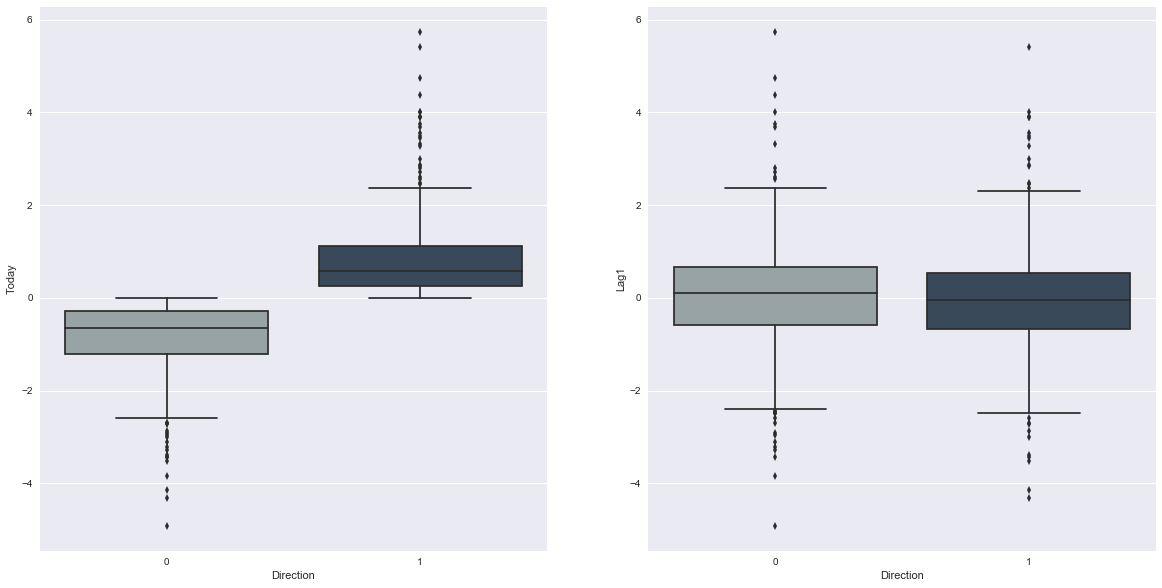

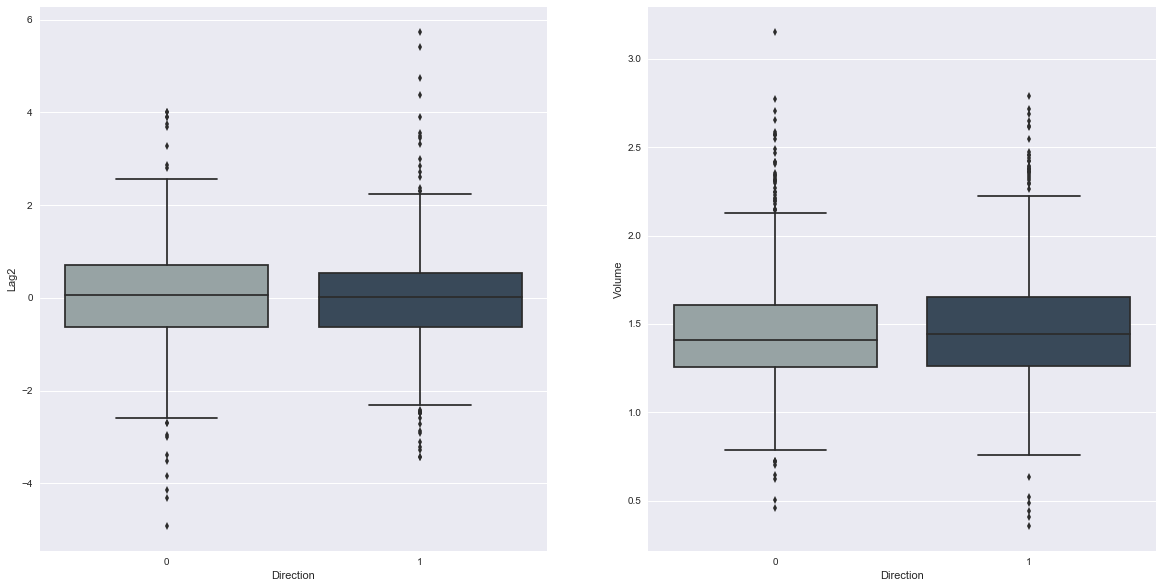

In [48]:
plotBoxplotOfReturnVariables()

### Display Perason Heatmaps to depict correlation b/w features and output variables

In [49]:
def plotPearsonHeatMap(data):
    '''
    Use Pearson Correlation metric to understand the relationship/correlation between the feature variables and the output
    '''
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


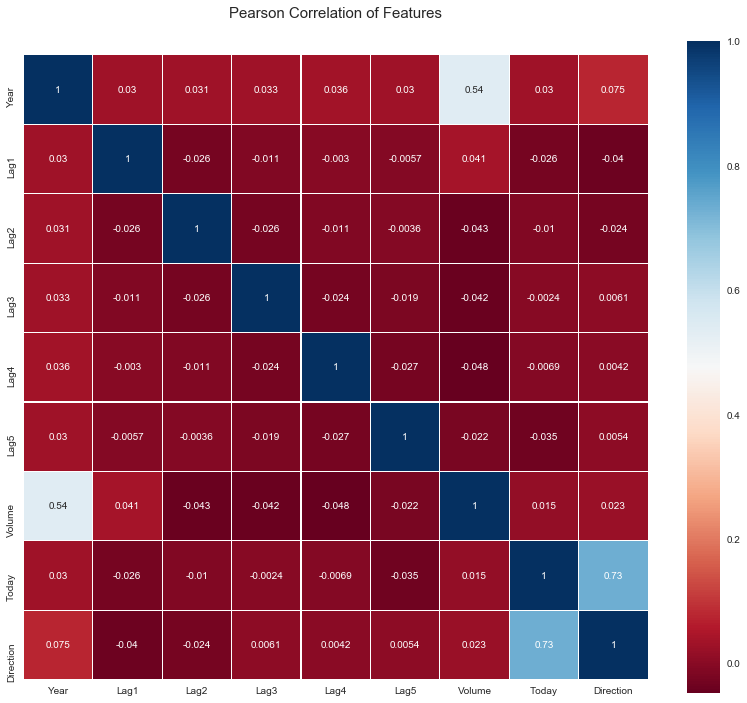

In [50]:
plotPearsonHeatMap(stock_market_data_table)

### Pre-process the data to improve the predictive power by following these steps: 
 - Identify data features/inputs (X) and responses/output (y) 
 - Rescale X data using Standardization, i.e ensure all of the vectors of X have a mean value of zero and a standard deviation of 1
 - Split the Data into Training and Valuation patitions

In [62]:
def identifyFeaturesAndResponses():
    '''
    Identify data features/inputs (X) and responses/output (y)
    '''
    n_cols = len(cols) - 1
    stock_market_data_table.columns = range(len(stock_market_data_table.columns))
    stock_market_data = stock_market_data_table.as_matrix()
    X = stock_market_data[:,0:n_cols]
    y = stock_market_data[:,n_cols]
    y = y.reshape(y.shape[0], 1)
    return X, y

def standardizeData(X):
    '''
    Rescale X feature data to have zero mean and unit variance
    '''
    scaler = StandardScaler()
    scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

def splitData(X, y, split_fraction=0.3, rand_seed = 10):
    '''
    Split the Data into Training and Valuation patitions
    '''
    X_train, X_val, y_train, y_val = smo.train_test_split(X, y, test_size=split_fraction, random_state=rand_seed)
    return (X_train, X_val, y_train, y_val)

def samplePreprocessedData(X_train, X_val, y_train, y_val):
    print("Sample of pre-processed X_train data:\n\n{}\n".format(pd.DataFrame(X_train[:3,:])))
    print("Sample of pre-processed X_val data:\n\n{}\n".format(pd.DataFrame(X_val[:3,:])))
    print("Sample of pre-processed y_train data:\n\n{}\n".format(pd.DataFrame(y_train[:3,:])))
    print("Sample of pre-processed y_val data:\n\n{}\n".format(pd.DataFrame(y_val[:3,:])))
    

def preprocessData():
    '''
     Pre-process the data to improve the predictive power of our model(s)
    '''
    X, y = identifyFeaturesAndResponses()
    #print("X.shape: {0}\ty.shape: {1}".format(X.shape, y.shape))
    scaler, X_scaled = standardizeData(X)
    X_train, X_val, y_train, y_val = splitData(X_scaled, y)
    samplePreprocessedData(X_train, X_val, y_train, y_val)
    return (X_train, X_val, y_train, y_val)


In [68]:
X_train, X_val, y_train, y_val = preprocessData()

Sample of pre-processed X_train data:

          0         1         2         3         4         5         6  \
0  1.408636 -0.676003 -0.652318  0.063505  0.622290  0.077928  1.254744   
1  1.408636 -0.065884  0.432356  0.317404  0.193587  0.219155  0.655793   
2 -1.431356  0.487008 -0.098536  0.209343  0.916584  1.396916 -0.969163   

          7  
0 -0.238703  
1 -0.183240  
2  0.338823  

Sample of pre-processed X_val data:

          0         1         2         3         4         5         6  \
0  1.408636  1.473939  0.130373 -1.321080  1.312782 -0.881019  1.997388   
1  0.698638 -0.057080  0.281805  1.332122 -0.019007  0.367356 -0.166304   
2 -0.011360 -1.057217 -0.726273  0.880550 -0.563670  0.139824  0.288149   

          7  
0 -0.211412  
1  0.584447  
2  0.476161  

Sample of pre-processed y_train data:

     0
0  0.0
1  0.0
2  1.0

Sample of pre-processed y_val data:

     0
0  0.0
1  1.0
2  1.0



### Create the Index Direction Prediction Models
 - Identify suitable ML classification models for this problem
 - Define the ML model imports for the selected ML classifers
 - Create a wrapper helper class to invoke ML models fin a convinient/consistent way
 - Specify classifier parameters using a dictionary data structure
 - Define a wrapper class to specify the MLP Neural Net using Keras (with a Tensorflow backend)
 - Construct the each ML models, train them, use them to predict the index direction and evaluate the models performance

### Identify suitable ML classification models for this problem
There will be a number of classifiers in this implementation namely:
 - Random Forest
 - Logistic Regression
 - K-Nearest Neighbors
 - Naive Baysian
 - Multi Layer Perceptron Neural Net

### Define the ML model imports

In [69]:
from sklearn.model_selection import (train_test_split, KFold)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Create a wrapper helper classto invoke ML models fin a convinient/consistent way

In [70]:
class SklearnHelper(object):
    '''
    Helper Class to wrap the Sklearn classifiers
    '''
    def __init__(self, clf, seed=0, params=None):
        if seed is not None:
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

### Specify classifier parameters using a dictionary data structure

In [71]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

lr_params = {
     #'random_state':SEED,
    'solver':'lbfgs',
    'max_iter':500
}

knn_params = {
    'n_neighbors':5,
    'leaf_size':30,
    'n_jobs':-1
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

nb_params = {
   
}

N_FEATURES = X_train.shape[1]
mlp_params = {
    'n_cols':N_FEATURES,
    'layer_activations':('relu', 'relu', 'relu', 'sigmoid'),
    'layer_nodes': (20,10,10,1),
    'epoch':100,
    'batch_size':10,
    'optimizer':'adam',
    'loss':'binary_crossentropy',
    'metrics':['accuracy'],
    'l2_reg':0.0
}


### Define a wrapper class to specify the MLP Neural Net using Keras (with a Tensorflow backend)
 - Define the module imports
 - Specify the helper class for the Nueral Net model

#### Define the module imports

In [72]:
import keras.models as km
import keras.layers as kl
from keras.regularizers import l2
from tensorflow import set_random_seed
SEED = 10
set_random_seed(10)

#### Specify the helper class for the Nueral Net model

In [73]:
class MlpNNModel(object):
    def __init__(self, n_cols, layer_activations, layer_nodes, epoch = 150, batch_size=10, 
                 optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], l2_reg=0.0001):
        self.n_cols = n_cols
        self.layer_activations = layer_activations
        self.layer_nodes = layer_nodes
        self.n_layers = len(layer_activations)
        # Make sure the number of activations == number of sets of nodes
        if len(layer_activations) != len(layer_activations):
            raise Exception("Error!!\n Make sure the number of activations == number of sets of nodes!!")
        self.epoch = epoch
        self.batch_size = batch_size
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        self.l2_reg = l2_reg
        self.model = km.Sequential()
        self.is_complied = False
        
    def fit2(self, x, y):
        return self.model.fit(x, y, epochs=self.epoch, batch_size=self.batch_size)
        
    def fit(self,x, y):
        if self.is_complied:
            return self.fit2(x, y)
        layer_data = list(zip(self.layer_nodes, self.layer_activations))
        for i, (num_nodes, activation) in enumerate(layer_data):
            if i==0:
                self.model.add(kl.Dense(num_nodes, input_dim=self.n_cols, activation=activation, 
                                        kernel_regularizer=l2(self.l2_reg), bias_regularizer=l2(self.l2_reg),
                                       activity_regularizer=l2(self.l2_reg)))
            else:
                self.model.add(kl.Dense(num_nodes, activation=activation, 
                                        kernel_regularizer=l2(self.l2_reg), bias_regularizer=l2(self.l2_reg),
                                       activity_regularizer=l2(self.l2_reg)))
        # Compile model
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        self.complied = True
        self.fit2(x, y)
        
    def predict(self, x):
        return self.model.predict(x)

### Construct the each ML models, train them, use them to predict the index direction and evaluate the models performance


In [74]:
def createMLModels():
    '''
    Creates the ML models
    '''
    models = {}
    models['rf'] = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
    models['nb'] = SklearnHelper(clf=GaussianNB, seed=None, params=nb_params)
    models['lr'] = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
    models['knn'] = SklearnHelper(clf=KNeighborsClassifier, seed=None, params=knn_params)
    models['mlp'] = SklearnHelper(clf=MlpNNModel, seed=None, params=mlp_params)
    return models

def reportClassificationMetrics(model_name, y_true, y_hat):
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    print("Model is: {}".format(model_name))
    print("Accuracy is {0}".format(accuracy))
    print("Confusion Matrix is\n {0}\n\n".format(conf_matrix))
    return accuracy, conf_matrix

def runModels():
    print("Starting the training of the ML classification models..\n")
    y_predict_accuracy = {}
    y_predict_conf_matrix = {}
    y_predict_results = {}
    models = createMLModels()
    for name, model in models.items():
        print("Training the {} model:".format(name))
        model.train(X_train, y_train)
        y_predict_results[name] = model.predict(X_val)
        if name == 'mlp':
            y_predict_results[name] = np.round(np.ravel(y_predict_results[name]))
        print("type(y_test) = {0} and type(y_hat) = {1}".format(y_val[:5], y_predict_results[name][:5]))
        y_predict_accuracy[name], y_predict_conf_matrix[name] = reportClassificationMetrics(name, y_val, y_predict_results[name])
    return y_predict_results, y_predict_accuracy, y_predict_conf_matrix

y_predict_results, y_predict_accuracy, y_predict_conf_matrix = runModels()

Starting the training of the ML classification models..

Training the knn model:
type(y_test) = [[0.]
 [1.]
 [1.]
 [1.]
 [1.]] and type(y_hat) = [1. 1. 1. 1. 1.]
Model is: knn
Accuracy is 0.88
Confusion Matrix is
 [[154  26]
 [ 19 176]]


Training the mlp model:


C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
875/875 [==============================] - 0s - loss: 0.6510 - acc: 0.6583     
Epoch 2/100
875/875 [==============================] - 0s - loss: 0.5070 - acc: 0.8206     
Epoch 3/100
875/875 [==============================] - 0s - loss: 0.3223 - acc: 0.9074     
Epoch 4/100
875/875 [==============================] - 0s - loss: 0.1922 - acc: 0.9509     
Epoch 5/100
875/875 [==============================] - 0s - loss: 0.1299 - acc: 0.9669     
Epoch 6/100
875/875 [==============================] - 0s - loss: 0.0974 - acc: 0.9760     
Epoch 7/100
875/875 [==============================] - 0s - loss: 0.0758 - acc: 0.9829     
Epoch 8/100
875/875 [==============================] - 0s - loss: 0.0620 - acc: 0.9863     
Epoch 9/100
875/875 [==============================] - 0s - loss: 0.0518 - acc: 0.9920     
Epoch 10/100
875/875 [==============================] - 0s - loss: 0.0431 - acc: 0.9977     
Epoch 11/100
875/875 [==============================] - 0s - loss: 0.0365 - acc

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


type(y_test) = [[0.]
 [1.]
 [1.]
 [1.]
 [1.]] and type(y_hat) = [0. 1. 1. 1. 1.]
Model is: lr
Accuracy is 0.984
Confusion Matrix is
 [[176   4]
 [  2 193]]


Training the rf model:


C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


type(y_test) = [[0.]
 [1.]
 [1.]
 [1.]
 [1.]] and type(y_hat) = [0. 1. 1. 1. 1.]
Model is: rf
Accuracy is 1.0
Confusion Matrix is
 [[180   0]
 [  0 195]]




In [75]:
X_train.shape, X_val.shape

((875, 8), (375, 8))

### Evaluate the performance of each prediction model
 - Outline the Confusion metrics of each model:
     
 - Outline the scores/performance metrics of each model, metrics used here are:
     - Error/Accuracy
     - Per-class Error
     - True_positive_rate (sensitivity/recall)
     - True_negative_rate (specificity)
     - Precision

### Outline the Confusion metrics of each model:
The confusion matrix (or error matrix) is one way to summarize the performance of a classifier for binary classification tasks. This square matrix consists of columns and rows that list the number of instances as absolute or relative "actual class" vs. "predicted class" ratios. - [REF: Sebastian Raschka](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/) 

![title](images/confusion_matrix.png)

In [78]:
from mlxtend.plotting import plot_confusion_matrix

def computeConfusionMatrixForModels():
    '''
    Computes the Confusion metrics of each model
    '''
    def plotConfusionMatrix(matrix, model):
        print("Confusion Matrix for the '{}' model:\n".format(model))
        fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(5.0,5.0))
        #axx = plt.figure(figsize=(14,8))
        plt.show()
        print("\n\n")
    models = ['rf', 'nb', 'lr', 'knn', 'mlp']
    for model in models:
        plotConfusionMatrix(y_predict_conf_matrix[model], model)


Confusion Matrix for the 'rf' model:



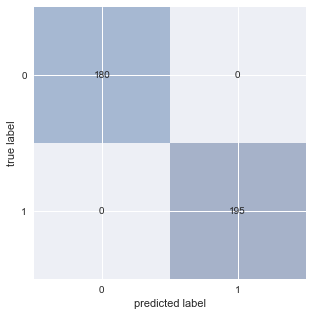




Confusion Matrix for the 'nb' model:



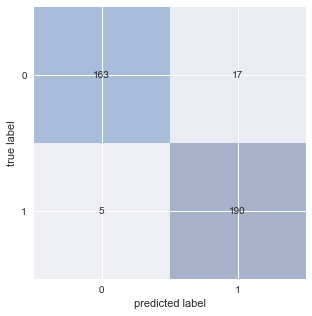




Confusion Matrix for the 'lr' model:



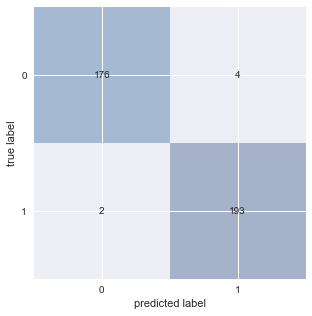




Confusion Matrix for the 'knn' model:



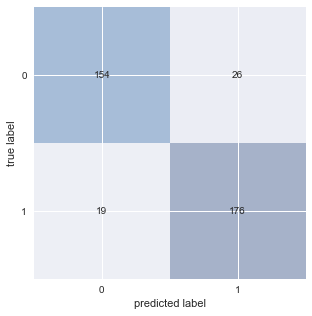




Confusion Matrix for the 'mlp' model:



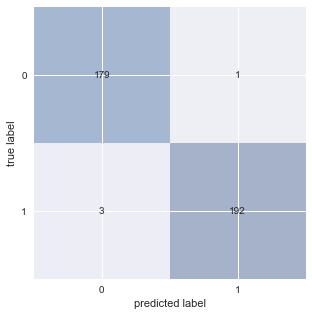

In [77]:
computeConfusionMatrixForModels()

### Outline the scores/performance metrics of each model, metrics used here are:
 - Error: (FP + FN)/(FP + FN + TP + TN)
 - Accuracy: 1 - Error
 - Per-class Accuracy: (TP + TN)/n 
 - True_positive_rate (sensitivity/recall): TP/(TP + FN)
 - True_negative_rate (specificity): TN/(TN + FP)
 - Precision: TP/(TP + FP)

In [79]:
from mlxtend.evaluate import scoring

def reportScoresForAllModels():
    '''
     Compute scores for all the models
    '''
    errors = []
    accuracies = []
    per_class_accs = []
    sens = []
    spes = []
    precisions = []
    cols = ['Error', 'Accuracy', 'Per-class Acc', 'Sen', 'Spe', 'Precision']
    models = ['rf', 'nb', 'lr', 'knn', 'mlp']
    for model in models:
        error = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='error')
        accuracy = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='accuracy')
        per_class_acc = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='per-class accuracy')
        sen = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='true_positive_rate')
        spe = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='true_negative_rate')
        precision = scoring(y_target=np.ravel(y_val), y_predicted=y_predict_results[model], metric='precision')
        errors.append(error)
        accuracies.append(accuracy)
        per_class_accs.append(per_class_acc)
        sens.append(sen)
        spes.append(spe)
        precisions.append(precision)
    data = np.array([errors, accuracies, per_class_accs, sens, spes, precisions], dtype=np.float32).T
    result = pd.DataFrame(data=data, index=models, columns=cols)
    result.index.name = 'Models'
    #result = pd.DataFrame(data=data, columns=cols)
    #data = errors
    print("Performance scores for all the models:\n\n{}\n\n".format(tabulate(result, headers='keys', tablefmt='psql')))


In [80]:
reportScoresForAllModels()

Performance scores for all the models:

+----------+-----------+------------+-----------------+----------+----------+-------------+
| Models   |     Error |   Accuracy |   Per-class Acc |      Sen |      Spe |   Precision |
|----------+-----------+------------+-----------------+----------+----------+-------------|
| rf       | 0         |   1        |        1        | 1        | 1        |    1        |
| nb       | 0.0586667 |   0.941333 |        0.941333 | 0.974359 | 0.905556 |    0.917874 |
| lr       | 0.016     |   0.984    |        0.984    | 0.989744 | 0.977778 |    0.979695 |
| knn      | 0.12      |   0.88     |        0.88     | 0.902564 | 0.855556 |    0.871287 |
| mlp      | 0.0106667 |   0.989333 |        0.989333 | 0.984615 | 0.994444 |    0.994819 |
+----------+-----------+------------+-----------------+----------+----------+-------------+




### Conclusions & Future work
 - Working on implementing this solution using C# and .Net libraries/frameworks:
     - [Accord](http://accord-framework.net/index.html)
     - [ML.NET](https://www.microsoft.com/net/apps/machinelearning-ai/ml-dotnet)
     - [CNTK](https://github.com/microsoft/cntk)
     - [Keras#](https://github.com/cesarsouza/keras-sharp)
     - [Azure AI](https://azure.microsoft.com/en-gb/overview/ai-platform/)
 - Future analysis of problem such as broading the exploration period beyond current window of 2001 - 2005
 - Further fucture extraction/selection analysis
 - Investigating practical areas in Credit Risk IT where ML can add value:
     - Understanding our log data indexed by Splunk. Is there any untapped value or patterns that we can discover with ML to pre-emptively resolve prod issues
     - Providing predictive analytics capability for our risk data such as time series analysis of data we push into RDF

### Question & Answers